# Correlogram Analysis

This notebook analyzes the results from correlogram experiments.

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob

# Define problem ordering
problem_ordering = [
    'OneMax', 
    #'HelloWorld', 
    'Sphere',
    #'TSP', 
    'NeuralNetwork',
    'SymbolicRegression', 
    'GrammaticalEvolution', 
    ]

## 1. Summary Statistics from Main Results

Read the main CSV results file and create a grouped summary table.

In [81]:
# Read main results file
df = pd.read_csv('outputs/results_2026_01_07_correlogram.csv')
df.head()

,Unnamed: 0,problem,size,size_cat,solver,budget,dist_type,name_type,rep,elapsed,cor_length,onestep_cor,diameter
0,0,OneMax,8,small,correlogram,50,coarse,lin,0,22.393849,3.963867,0.737778,8.090000
1,1,OneMax,8,small,correlogram,50,coarse,str,0,24.085686,3.963867,0.737778,8.090000
2,2,OneMax,8,small,correlogram,50,fine,lin,0,22.603326,3.942794,0.704325,8.090000
3,3,OneMax,8,small,correlogram,50,fine,str,0,23.683787,3.942794,0.704325,8.090000
4,4,OneMax,16,medium,correlogram,200,coarse,lin,0,41.935266,8.033402,0.809189,15.653333


In [82]:
# Create groupby table across problem / size / dist_type / name_type
# Note: The main results file should have columns for diameter, cor_length, and onestep_cor
# If there are multiple reps, we'll aggregate (mean)

groupby_cols = ['problem', 'size', 'dist_type', 'name_type']

# Check if diameter is in the dataframe (it might not be if not saved)
# If not, we'll just show cor_length and onestep_cor
if 'diameter' in df.columns:
    summary_cols = ['diameter', 'cor_length', 'onestep_cor']
else:
    summary_cols = ['cor_length', 'onestep_cor']

summary_table = df.groupby(groupby_cols)[summary_cols].mean()

# Apply problem ordering
summary_table = summary_table.reset_index()
summary_table['problem'] = pd.Categorical(summary_table['problem'], categories=problem_ordering, ordered=True)
summary_table = summary_table.sort_values(['problem', 'size', 'dist_type', 'name_type'])
summary_table = summary_table.set_index(groupby_cols)

summary_table

diameter  cor_length  \
problem              size dist_type name_type                          
OneMax               8    coarse    lin         8.090000    3.963867   
                                    str         8.090000    3.963867   
                          fine      lin         8.090000    3.942794   
                                    str         8.090000    3.942794   
                     16   coarse    lin        15.653333    8.033402   
                                    str        15.653333    8.033402   
                          fine      lin        15.653333    8.000567   
                                    str        15.653333    8.000567   
Sphere               8    coarse    lin        16.000000    7.700378   
                                    str        16.000000    7.700378   
                          fine      lin         5.442588    2.458261   
                                    str         5.442588    2.458261   
                     16   coarse    lin        32.000000   14.420874   
                                    str        32.000000   14.420874   
                          fine      lin        10.530992    5.135775   
                                    str        10.530992    5.135775   
NeuralNetwork        2    coarse    lin        30.010000    6.946228   
                                    str        30.010000    6.934042   
                          fine      lin        20.287794    4.927825   
                                    str        20.216113    5.793460   
                     4    coarse    lin        89.480000   20.901823   
                                    str        89.480000   17.012081   
                          fine      lin        61.461633   13.146286   
                                    str        61.707093   16.466528   
SymbolicRegression   6    coarse    lin        12.114286    1.848150   
                                    str        13.551429    1.820600   
                          fine      lin        10.508846    2.192439   
                                    str        12.083029    3.297502   
                     9    coarse    lin         8.730000    1.883673   
                                    str         9.565000    1.890893   
                          fine      lin         7.227593    1.093104   
                                    str         8.099597    2.554379   
GrammaticalEvolution 3    coarse    lin        20.000000    1.000000   
                                    str        22.405714    2.823169   
                          fine      lin        20.000000    3.745637   
                                    str        22.405714    9.210907   
                     6    coarse    lin        20.171429    7.818133   
                                    str        22.480000    9.625468   
                          fine      lin        20.171429    7.921874   
                                    str        22.480000    2.831464   

                                               onestep_cor  
problem              size dist_type name_type               
OneMax               8    coarse    lin           0.737778  
                                    str           0.737778  
                          fine      lin           0.704325  
                                    str           0.704325  
                     16   coarse    lin           0.809189  
                                    str           0.809189  
                          fine      lin           0.886912  
                                    str           0.886912  
Sphere               8    coarse    lin           0.862602  
                                    str           0.862602  
                          fine      lin           0.967724  
                                    str           0.967724  
                     16   coarse    lin           0.942475  
                                    str           0.942475  
                          fine      lin        

In [83]:
# Save the summary table to CSV
summary_table.to_csv('outputs/correlogram_summary_table.csv')
print("Summary table saved to outputs/correlogram_summary_table.csv")

# Export to LaTeX
latex_str = summary_table.to_latex(float_format="%.3f")
with open('outputs/correlogram_summary_table.tex', 'w') as f:
    f.write(latex_str)
print("Summary table saved to outputs/correlogram_summary_table.tex")

Summary table saved to outputs/correlogram_summary_table.csv
Summary table saved to outputs/correlogram_summary_table.tex


## 2. Plot Correlogram Curves

Read each xy results file and create plots in PDF format.

In [84]:
# Find all xy CSV files
xy_files = glob.glob('outputs/results_2026_01_07_correlogram_xy_*.csv')
print(f"Found {len(xy_files)} xy files to plot")

Found 42 xy files to plot


In [85]:
# Create plots for each xy file and save as PDF
for xy_file in xy_files:
    # Read the xy data
    xy_df = pd.read_csv(xy_file)
    
    # Extract metadata from filename
    # Format: results_2026_01_07_correlogram_xy_{problem}_{size}_{size_cat}_{budget}_{dist_type}_{name_type}_rep{rep}.csv
    filename = Path(xy_file).stem
    parts = filename.replace('results_2026_01_07_correlogram_xy_', '').split('_')
    
    # Log-scaled marker sizes based on n_axis
    if 'n_axis' in xy_df.columns:
        marker_sizes = np.log10(xy_df['n_axis'] + 1) * 30
    else:
        marker_sizes = 50  # default if n_axis not available
    
    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.scatter(xy_df['x_axis'], xy_df['y_axis'], s=marker_sizes, alpha=0.7, edgecolors='black', linewidth=0.5)
    plt.plot(xy_df['x_axis'], xy_df['y_axis'], linestyle='-', linewidth=1, alpha=0.4, color='gray')
    plt.xlabel('Distance', fontsize=12)
    plt.ylabel('Correlation', fontsize=12)
    plt.title(filename.replace('results_2026_01_07_correlogram_xy_', '').replace('_', ' '), fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    
    # Add legend for marker sizes if n_axis is available
    if 'n_axis' in xy_df.columns:
        from matplotlib.lines import Line2D
        n_min, n_max = xy_df['n_axis'].min(), xy_df['n_axis'].max()
        n_reference = [10, 100, 1000, 10000, 100000]
        n_reference = [n for n in n_reference if n_min <= n <= n_max]
        if len(n_reference) > 0:
            legend_elements = [Line2D([0], [0], marker='o', color='w', 
                                      markerfacecolor='gray', 
                                      markersize=np.sqrt(np.log10(n+1)*30/np.pi),
                                      label=f'n={n:,}') 
                               for n in n_reference]
            plt.legend(handles=legend_elements, title='Pairs per bin', loc='best', framealpha=0.9, fontsize=9)
        
        # Add text showing range
        plt.text(0.02, 0.98, f'n range: {int(n_min):,}-{int(n_max):,}', 
                 transform=plt.gca().transAxes, 
                 verticalalignment='top',
                 fontsize=8,
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    # Save as PDF
    pdf_filename = xy_file.replace('.csv', '.pdf')
    plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
    plt.close()
    
print(f"Created {len(xy_files)} PDF plots")

Created 42 PDF plots


## 3. Summary Statistics by Problem Type

Additional analysis grouping by different dimensions.

## 2b. Display Correlogram Plots in Grid

Display all correlogram plots in a grid layout within the notebook.

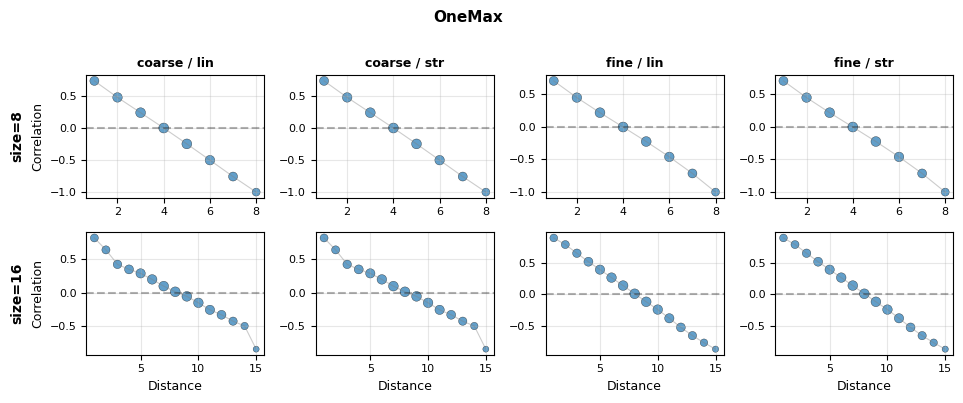

Created grid for OneMax with 2 sizes: [8, 16]


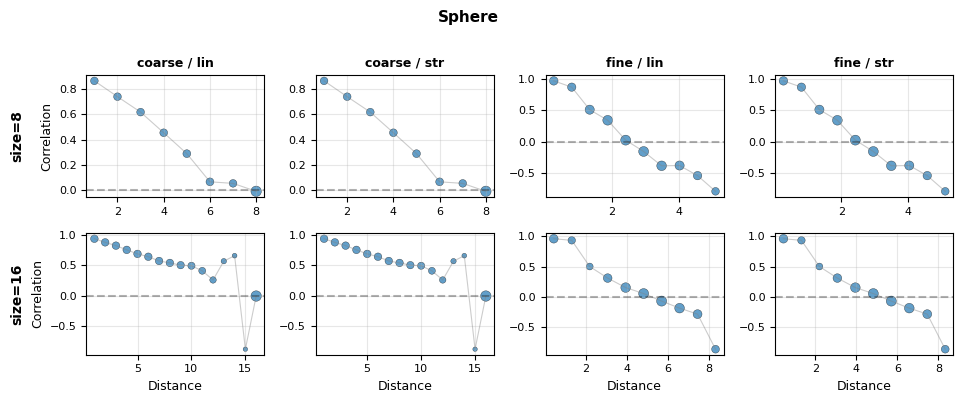

Created grid for Sphere with 2 sizes: [8, 16]


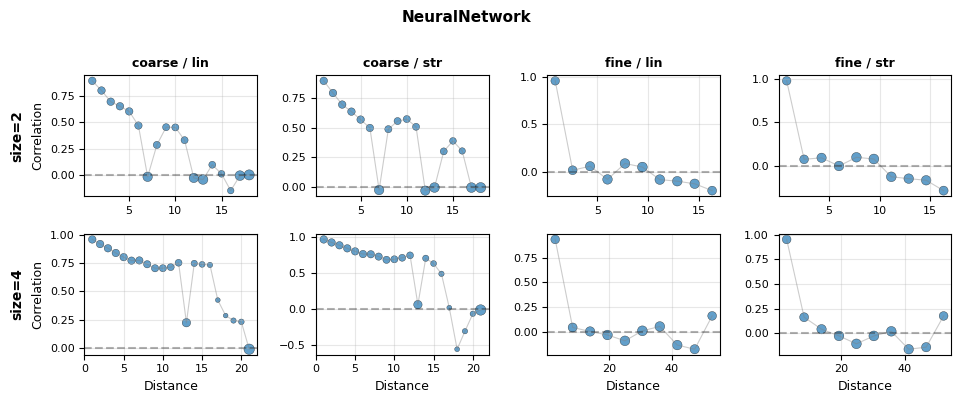

Created grid for NeuralNetwork with 2 sizes: [2, 4]


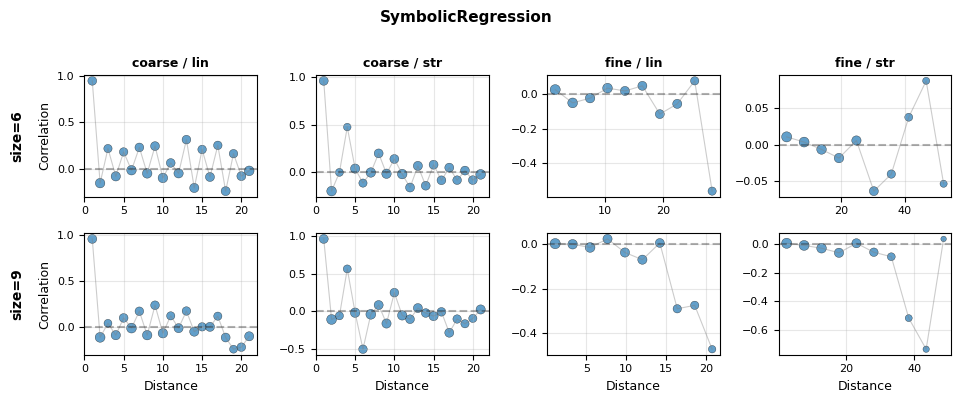

Created grid for SymbolicRegression with 2 sizes: [6, 9]


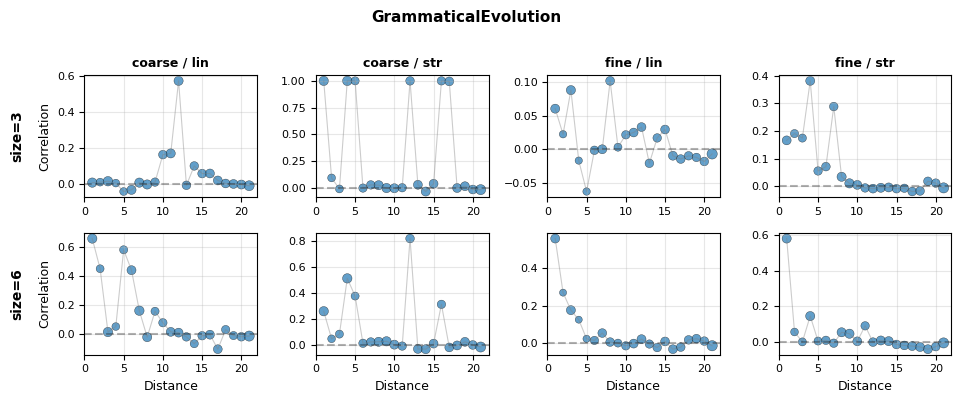

Created grid for GrammaticalEvolution with 2 sizes: [3, 6]
Created grids for 6 problems


In [86]:
# Create a grid of plots - one grid per problem
# Within each grid: rows = problem sizes, columns = name_type x dist_type

# Parse filenames to get metadata
plot_data = []
for xy_file in xy_files:
    filename = Path(xy_file).stem
    # Extract parts from filename
    parts = filename.replace('results_2026_01_07_correlogram_xy_', '').split('_')
    
    # Parse: {problem}_{size}_{size_cat}_{budget}_{dist_type}_{name_type}_rep{rep}
    try:
        problem = parts[0]
        size = int(parts[1])
        size_cat = parts[2]
        budget = int(parts[3])
        dist_type = parts[4]
        name_type = parts[5]
        rep = parts[6].replace('rep', '')
        
        plot_data.append({
            'file': xy_file,
            'problem': problem,
            'size': size,
            'size_cat': size_cat,
            'budget': budget,
            'dist_type': dist_type,
            'name_type': name_type,
            'rep': rep
        })
    except:
        print(f"Warning: Could not parse {filename}")

# Convert to DataFrame
plot_df = pd.DataFrame(plot_data)
plot_df['problem'] = pd.Categorical(plot_df['problem'], categories=problem_ordering, ordered=True)
plot_df = plot_df.sort_values(['problem', 'size', 'dist_type', 'name_type'])

# Get unique problems and combinations
problems = plot_df['problem'].unique()
dist_types = sorted(plot_df['dist_type'].unique())
name_types = sorted(plot_df['name_type'].unique())

# Create column labels for all combinations of dist_type x name_type
columns = [(dt, nt) for dt in dist_types for nt in name_types]

# Create one grid per problem
for problem in problems:
    problem_df = plot_df[plot_df['problem'] == problem]
    
    if len(problem_df) == 0:
        continue
    
    # Get sizes that actually exist for this problem
    sizes = sorted(problem_df['size'].unique())
    
    # Determine grid dimensions
    n_rows = len(sizes)
    n_cols = len(columns)
    
    # Create figure with smaller size - better for papers
    # Each subplot is 2.5" x 2" instead of 5" x 4"
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2.5*n_cols, 2*n_rows))
    
    # Handle case of single row or column
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    fig.suptitle(f'{problem}', fontsize=11, fontweight='bold', y=0.995)
    
    # Plot each cell
    for row_idx, size in enumerate(sizes):
        for col_idx, (dist_type, name_type) in enumerate(columns):
            ax = axes[row_idx, col_idx]
            
            # Find the matching file
            matching = problem_df[
                (problem_df['size'] == size) & 
                (problem_df['dist_type'] == dist_type) & 
                (problem_df['name_type'] == name_type)
            ]
            
            if len(matching) > 0:
                # Read the xy data
                xy_df = pd.read_csv(matching.iloc[0]['file'])
                
                # Log-scaled marker sizes based on n_axis (smaller for smaller figure)
                if 'n_axis' in xy_df.columns:
                    marker_sizes = np.log10(xy_df['n_axis'] + 1) * 10
                else:
                    marker_sizes = 15
                
                # Plot
                ax.scatter(xy_df['x_axis'], xy_df['y_axis'], s=marker_sizes, alpha=0.7, 
                          edgecolors='black', linewidth=0.3)
                ax.plot(xy_df['x_axis'], xy_df['y_axis'], linestyle='-', linewidth=0.8, 
                       alpha=0.4, color='gray')
            else:
                # No data for this combination (shouldn't happen now, but keep as fallback)
                ax.text(0.5, 0.5, 'No data', transform=ax.transAxes, 
                       ha='center', va='center', fontsize=8, color='gray')
            
            # Formatting
            ax.grid(True, alpha=0.3)
            ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
            
            # Labels with appropriate font sizes for smaller figure
            if row_idx == n_rows - 1:
                ax.set_xlabel('Distance', fontsize=9)
            if col_idx == 0:
                ax.set_ylabel('Correlation', fontsize=9)
            
            # Tick label sizes
            ax.tick_params(axis='both', labelsize=8)
            
            # Row labels (size)
            if col_idx == 0:
                ax.text(-0.35, 0.5, f'size={size}', transform=ax.transAxes,
                       fontsize=10, va='center', ha='right', fontweight='bold',
                       rotation=90)
            
            # Column labels (dist_type, name_type)
            if row_idx == 0:
                ax.set_title(f'{dist_type} / {name_type}', fontsize=9, fontweight='bold')
    
    plt.tight_layout(rect=[0.03, 0, 1, 0.99])
    plt.savefig(f'outputs/correlogram_grid_{problem}.pdf', format='pdf', bbox_inches='tight', dpi=300)
    plt.show()
    
    print(f"Created grid for {problem} with {len(sizes)} sizes: {sizes}")

print(f"Created grids for {len(problems)} problems")

In [87]:
# Group by problem only
by_problem = df.groupby('problem')[summary_cols].mean()
print("\nMean values by problem:")
by_problem


Mean values by problem:


,diameter,cor_length,onestep_cor
problem,,,
GrammaticalEvolution,21.264286,5.622082,0.411572
NeuralNetwork,50.331579,11.516034,0.940759
OneMax,11.871667,5.985158,0.784551
Sphere,15.993395,7.428822,0.932575
SymbolicRegression,10.234972,2.072592,0.483357


In [88]:
# Group by size only
by_size = df.groupby('size')[summary_cols].mean()
print("\nMean values by size:")
by_size


Mean values by size:


,diameter,cor_length,onestep_cor
size,,,
2,25.130977,6.150388,0.929385
3,21.202857,4.194928,0.308707
4,75.532181,16.881679,0.952132
6,16.695056,4.669454,0.499986
8,9.405647,4.516325,0.818107
9,8.405548,1.855512,0.481181
16,18.459415,8.897655,0.899018


In [89]:
# Group by dist_type and name_type
by_type = df.groupby(['dist_type', 'name_type'])[summary_cols].mean()
print("\nMean values by dist_type and name_type:")
by_type


Mean values by dist_type and name_type:


diameter  cor_length  onestep_cor
dist_type name_type                                    
coarse    lin        25.224905    7.451653     0.777504
          str        25.923548    7.422477     0.837789
fine      lin        17.937421    5.256456     0.605877
          str        18.670846    5.969164     0.621082